In [1]:
%matplotlib  inline
import jax
import jax_cosmo as jc
import jax.numpy as jnp
import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist
import powerbox_jax as pbj
import haiku as hk
import optax
from tqdm import tqdm
import corner
from tensorflow_probability.substrates import jax as tfp

In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [7]:
def model(N=64,                # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=50,   
          sigma_e=0.2):      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians

    
    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.TruncatedNormal(0.26, 0.1,low=0))
    sigma_8 = numpyro.sample('sigma_8', dist.TruncatedNormal(0.8, 0.1,low=0))
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer], nonlinear_fn=jc.power.linear)[0]
    # Warning!!!!: I was too lazy to figure out the proper conversion from k to ell 
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    pb = pbj.PowerBox(
        N=N,                                   # Number of grid-points in the box
        dim=2,                                 # 2D box
        pk = P,                                # The power-spectrum
        boxlength = map_size,                  # Size of the box (sets the units of k in pk)
        vol_normalised_power=True,             # normalise power by volume
        supplied_freqs=None
    )
      
    # Sampling field
    field = pb.delta_x()
    
    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [8]:
sample_map = numpyro.handlers.seed(model, jax.random.PRNGKey(0))

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


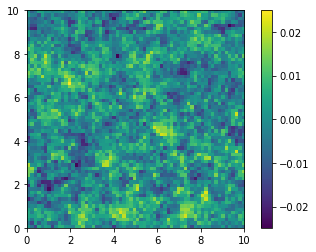

In [11]:
m = sample_map()
plt.imshow(m, extent=(0,10,0,10))
plt.colorbar()
plt.show()

In [14]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0.26, 'sigma_8': 0.77})
sample_map_fiducial = numpyro.handlers.seed(fiducial_model, jax.random.PRNGKey(12345670))
m_data = sample_map_fiducial()

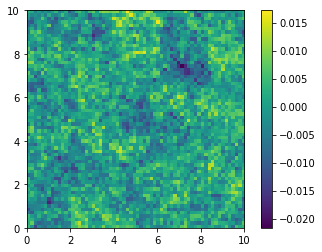

In [15]:
plt.imshow(m_data, extent=(0,10,0,10))
plt.colorbar()
plt.show()

### Training a neural network to learn a good summary stat ( compressor )

data

In [22]:
# Now we define a model conditioned on these values
def eval_model(key):

  cond_model = numpyro.handlers.seed(model, key)
  model_trace = numpyro.handlers.trace(cond_model).get_trace()
  
  return jnp.array([model_trace['omega_c']['value'], model_trace['sigma_8']['value'] ]) , model_trace['x']['value']

In [68]:
@jax.jit
def get_batch(key, batch_size=100):

  p, x = jax.vmap(eval_model)(jax.random.split(key, batch_size))
  
  return p, x

In [24]:
master_seed = hk.PRNGSequence(42)
p, x = get_batch(next(master_seed))
# p = omega_c and sigma_8
# x = observation

code

In [25]:
# This is a CNN that compresses the shear map into 2 statistics. 

class Compressor(hk.Module):

  def __call__(self, x):
    # x = shear map 
    x = x[..., jnp.newaxis]
    net_x = hk.Conv2D(32, 3, 2)(x) # 2d convolutional layer with 32 filters, 3 by 3 kernel, stride = 2 (the step) 
    net_x = jax.nn.leaky_relu(net_x) # activation function = leaky relu
    net_x = hk.Conv2D(64, 3, 2)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv2D(128, 3, 2)(net_x)
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.AvgPool(16,8,'SAME')(net_x) # pooling layer: it averages a 16 by 16 window with stride = 8
    net_x = hk.Flatten()(net_x) # flatten layer

    # Bottleneck
    net_x = hk.Linear(2)(net_x) # linear layer : net_x * weight + bias 
    # it return the  2 statistics

    return net_x.squeeze()

In [26]:
# hk.transform() -> Transforms a function using Haiku modules into a pair of pure functions : init() and apply()
# - init() : The init function, with signature params = init(rng, ...) (where '...' are the arguments to the untransformed function), 
#            allows you to collect the initial value of any parameters in the network. Haiku does this by running your function, 
#            keeping track of any parameters requested through hk.get_parameter (called by e.g. hk.Linear) and returning them to you.
# - apply() : The apply function, with signature result = apply(params, rng, ...), allows you to inject parameter values into your function.

12
# create the compressor method
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))

# init the params of the model
rng_seq = hk.PRNGSequence(0)
params_compressor = compressor.init(next(rng_seq), jnp.zeros([1,64,64]))

### Now that we have a compressor, let's try to learn the posterior

In [27]:
from sbiexpt.bijectors import MixtureAffineSigmoidBijector 

In [28]:
d = 2

class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, **kwargs):
    self.y = y
    super(CustomCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):

    net = jnp.concatenate([x, self.y], axis=-1)
    # NN to get a b and c
    net = hk.Linear(128, name='l1')(net)
    net = jax.nn.silu(net) # silu = x*sigmoid(x)
    net = hk.Linear(128, name='l2')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 16
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = jax.nn.softmax(hk.Linear(n_components, name='l6')(net))
    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c, p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self, y):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b2')),
            tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(jnp.array([0.3,0.8]), scale_identity_multiplier=0.05),
            bijector=chain)
      return nvp

In [29]:
nvp = hk.without_apply_rng(hk.transform(lambda p,y : Flow()(y).log_prob(p).squeeze()))

In [30]:
params_compressor = compressor.init(next(rng_seq), jnp.zeros([1,64,64]))
params_NF = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))
params=hk.data_structures.merge(params_compressor,params_NF)

In [31]:
def loss_fn(params, batch):
  y = compressor.apply(params, batch[1])
  log_prob = jax.vmap(lambda p, x: nvp.apply(params, p.reshape([-1,2]), x.reshape([-1,2])))(batch[0], y) # Here we extract the grad of the model
  return -jnp.mean(log_prob)

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

100%|█████████████████████████████████████████████████████████| 10000/10000 [54:43<00:00,  3.05it/s]


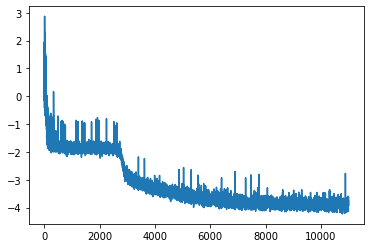

In [32]:
nb_simu = 1000
size_mini_batch = 100


# init model 
rng_seq = hk.PRNGSequence(12)

losses = []
master_seed = hk.PRNGSequence(1)


# training 
learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


it = 1000
for step in tqdm(range(it)):
  p, x= get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p, x))
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

it = 10000
for step in tqdm(range(it)):
  p, x= get_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, (p, x))
  losses.append(l)

plot(array(losses)[:])

In [33]:
p = jnp.stack(jnp.meshgrid(jnp.linspace(0.05,0.6,64),
                 jnp.linspace(0.1,1,64)), axis=-1)
ps = p.reshape([-1, 2])

y = compressor.apply(params,  m_data.reshape((1,64,64)).repeat(len(ps),axis=0))
pred_fn = nvp.apply(params, ps, y).reshape([64, 64])

Text(0, 0.5, '$\\sigma_8$')

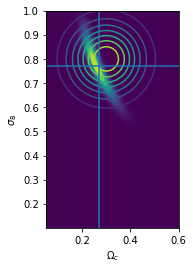

In [34]:
contourf(p[...,0], p[...,1], jnp.exp(pred_fn - pred_fn.max()), 256); 
contour(p[...,0], p[...,1], tfd.MultivariateNormalDiag([0.3,0.8], scale_identity_multiplier=0.1).prob(ps).reshape([64, 64]))
axvline(0.27)
axhline(0.77)
gca().set_aspect('equal')
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')

# Now that we have a compressor, let's try to learn the posterior

In [98]:
params_pdf = nvp.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros([1,2]))

In [99]:
def loss_fn(params2, batch):
  y = compressor.apply(params, batch[1])
  log_prob = jax.vmap(lambda p, x: nvp.apply(params2, p.reshape([-1,2]), x.reshape([-1,2])))(batch[0], y) # Here we extract the grad of the model
  return -jnp.mean(log_prob)


@jax.jit
def update(params2, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params2, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params2, updates)
  
    return loss, new_params, new_opt_state

In [66]:
# #@jax.jit
# import functools
# @functools.partial(jax.jit, static_argnums=(1,))
# def get_batch(key, batch_size=1000):

#   p, x = jax.vmap(eval_model)(jax.random.split(key, batch_size))
  
#   return p, x

In [100]:
nb_simu = 1000
size_mini_batch = 100


# init model 
rng_seq = hk.PRNGSequence(12)

losses = []
master_seed = hk.PRNGSequence(0)


# training 
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_pdf)


it = 1000
for step in tqdm(range(it)):
  p, x= get_batch(next(master_seed))
  l, params_pdf, opt_state = update(params_pdf, opt_state, (p, x))
  losses.append(l)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_pdf)


it = 10000
for step in tqdm(range(it)):
  p, x= get_batch(next(master_seed))
  l, params_pdf, opt_state = update(params_pdf, opt_state, (p, x))
  losses.append(l)

100%|█████████████████████████████████████| 10000/10000 [44:04<00:00,  3.78it/s]


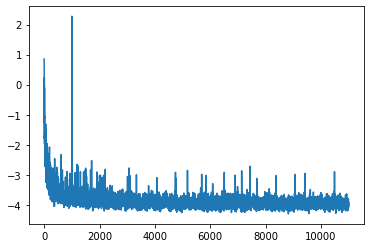

In [101]:
plot(array(losses)[:])

In [108]:
model_sample = hk.without_apply_rng(hk.transform(lambda : Flow()(y).sample(4096, seed=next(rng_seq))))
x = model_sample.apply(params_pdf)

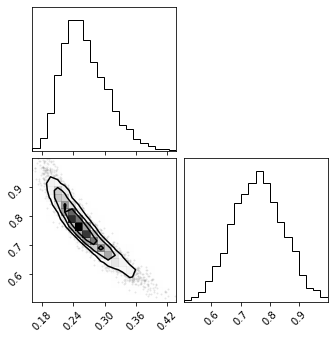

In [109]:

figure = corner.corner(np.array(x))
